In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy import stats as st
import warnings
from statsmodels.stats.proportion import proportions_ztest

In [124]:
marketplace_df = pd.read_csv('marketplace.csv')
marketplace_df.sample(5)

,Unnamed: 0,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount
11738,11738,2024-12-22 15:51:46,2024-12-22 16:15:03,1104245,М,desktop,одежда и обувь,True,10,4,925
7423,7423,2024-11-29 20:10:11,2024-11-29 20:27:05,3288117,М,mobile,детские товары,True,7,1,1683
3517,3517,2024-11-04 00:04:30,2024-11-04 00:44:29,8702785,Ж,desktop,детские товары,True,15,5,17944
11838,11838,2024-12-23 03:52:15,2024-12-23 04:05:15,1994529,Ж,mobile,одежда и обувь,False,0,4,7419
6634,6634,2024-11-24 18:21:57,2024-11-24 18:45:11,3257872,Ж,mobile,канцелярия,True,10,5,2024


In [125]:
marketplace_df = marketplace_df.drop('Unnamed: 0',axis = 1)

In [126]:
marketplace_df.shape

(13620, 10)

In [127]:
marketplace_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   start_session       13620 non-null  object
 1   end_session         13620 non-null  object
 2   user_id             13620 non-null  int64 
 3   sex                 13620 non-null  object
 4   platform            13620 non-null  object
 5   category            13620 non-null  object
 6   consultation        13620 non-null  bool  
 7   cons_duration       13620 non-null  int64 
 8   number_of_products  13620 non-null  int64 
 9   basket_amount       13620 non-null  int64 
dtypes: bool(1), int64(4), object(5)
memory usage: 971.1+ KB


#### В датафрейме нет пустых значений

In [128]:
marketplace_df.describe()

,user_id,cons_duration,number_of_products,basket_amount
count,1.362000e+04,13620.000000,13620.000000,13620.000000
mean,5.014737e+06,3.769971,3.480617,8070.579148
std,2.321852e+06,5.206834,1.717339,10664.396801
min,1.000078e+06,0.000000,1.000000,72.000000
25%,3.030951e+06,0.000000,2.000000,1203.750000
50%,4.995020e+06,0.000000,3.000000,3834.500000
75%,7.056691e+06,8.000000,5.000000,10171.500000
max,8.999642e+06,19.000000,6.000000,53385.000000


In [129]:
# переводим небходимые столбцы в дату
marketplace_df['start_session'] = pd.to_datetime(marketplace_df['start_session'])
marketplace_df['end_session'] = pd.to_datetime(marketplace_df['end_session'])

In [130]:
# поиск возможных пустых значенйи в столбце
def check_masked_missing(df, column):
        
        # 1. Стандартные NaN/None
        nan_count = df[column].isna().sum()
        print(f"NaN/None: {nan_count}")
        
        # 2. Пустые строки ''
        empty_str = (df[column] == '').sum()
        print(f"Пустые строки (''): {empty_str}")
        
        # 3. Пробелы ' ', '\\t', '\\n'
        whitespace = df[column].astype(str).str.strip().eq('').sum()
        print(f"Только пробелы: {whitespace}")
        
        # 4. Специальные символы: ?, -, N/A, NULL, пусто
        suspicious = df[column].astype(str).str.lower()
        masks = ['?', '-', 'n/a', 'na', 'null', 'none', 'nan', '','!']
        for mask in masks:
            count = (suspicious == mask).sum()
            if count > 0:
                print(f"'{mask}': {count}")
        
        # 5. Строки из пробелов разной длины
        space_only = suspicious.str.match(r'^\s*$').sum()
        print(f"Только пробелы (regex): {space_only}")
        

In [131]:
check_masked_missing(marketplace_df, 'end_session')

NaN/None: 0
Пустые строки (''): 0
Только пробелы: 0
Только пробелы (regex): 0


## Верно ли, что женщины тратят больше денег на покупки на ВезуМаркет?

In [132]:
marketplace_df['month'] = marketplace_df['end_session'].dt.strftime('%Y-%m')

In [133]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [134]:
# Разбивка расходов по месяцам
cost_df = marketplace_df.groupby(['month','sex'],as_index=False) \
    .agg({'basket_amount':'sum'}).rename(columns={'basket_amount':'total_spending'})
cost_df

,month,sex,total_spending
0,2024-10,Ж,12280043
1,2024-10,М,12809949
2,2024-11,Ж,17720267
3,2024-11,М,16891579
4,2024-12,Ж,25781533
5,2024-12,М,24437917


In [135]:
women_sum = cost_df[cost_df['sex'] == 'Ж']['total_spending'].sum()
print(f'Женщины потратили на ВезуМаркет: {women_sum} руб.')

Женщины потратили на ВезуМаркет: 55781843 руб.


In [136]:
men_sum = cost_df[cost_df['sex'] == 'М']['total_spending'].sum()
print(f'Мужчины в сумме потратили на ВезуМаркет: {men_sum} руб.')

Мужчины в сумме потратили на ВезуМаркет: 54139445 руб.


### H0: Средний чек мужчин и женщин на платформе ВезуМаркет одинаковый
### H1: Средний чек мужчин и женщин на платформе ВезуМаркет отличается

In [137]:
df_women = marketplace_df.query('sex == "Ж"')

In [138]:
df_women.sample(5)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
11672,2024-12-22 08:14:09,2024-12-22 08:30:50,3860345,Ж,desktop,красота и здоровье,False,0,6,482,2024-12
9408,2024-12-10 23:52:24,2024-12-11 00:05:38,3997400,Ж,mobile,одежда и обувь,False,0,4,19432,2024-12
10787,2024-12-17 22:56:19,2024-12-17 23:30:56,8255417,Ж,mobile,одежда и обувь,False,0,3,1529,2024-12
10831,2024-12-18 04:27:25,2024-12-18 04:47:35,7490328,Ж,mobile,электроника,False,0,4,43677,2024-12
6636,2024-11-24 18:37:46,2024-11-24 19:03:36,8329588,Ж,desktop,детские товары,False,0,2,6365,2024-11


In [139]:
df_women.shape

(6887, 11)

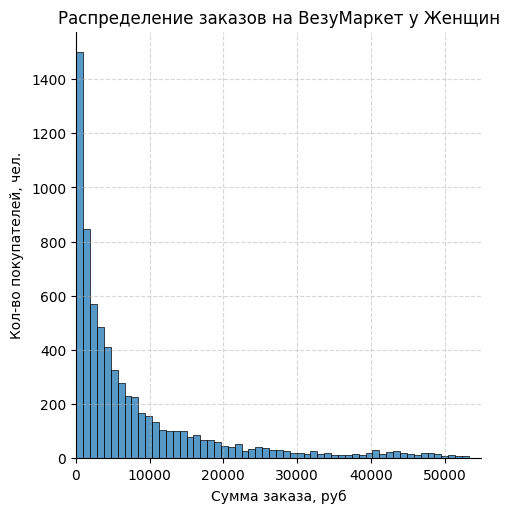

In [140]:
# визуализация
sns.displot(df_women["basket_amount"])
plt.xlabel('Сумма заказа, руб',labelpad=5)
plt.ylabel('Кол-во покупателей, чел.',labelpad=5)
plt.xlim(0, 55000)
plt.title('Распределение заказов на ВезуМаркет у Женщин')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [141]:
# основные показатели у женщин
print(f'Средний чек заказа на ВезуМаркет у женщин: {df_women["basket_amount"].mean():.0f} руб.')
print(f'Дисперсия суммы заказов на ВезуМаркет у женщин: {df_women["basket_amount"].var():.0f} руб.')
print(f'СКО суммы заказов на ВезуМаркет у женщиин: {np.std(df_women["basket_amount"]):.0f} руб.')

Средний чек заказа на ВезуМаркет у женщин: 8100 руб.
Дисперсия суммы заказов на ВезуМаркет у женщин: 113142487 руб.
СКО суммы заказов на ВезуМаркет у женщиин: 10636 руб.


In [142]:
df_men = marketplace_df.query('sex == "М"')

In [143]:
df_men.sample(5)

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
9649,2024-12-12 05:27:10,2024-12-12 05:39:36,6042357,М,desktop,все для дома,False,0,5,12808,2024-12
10238,2024-12-15 05:24:16,2024-12-15 05:56:30,3053556,М,mobile,канцелярия,False,0,3,1686,2024-12
8841,2024-12-08 01:46:11,2024-12-08 02:00:20,1308063,М,mobile,детские товары,False,0,4,21316,2024-12
13195,2024-12-29 20:44:33,2024-12-29 21:13:16,3144080,М,mobile,красота и здоровье,False,0,1,1122,2024-12
2003,2024-10-20 15:49:51,2024-10-20 16:03:22,4165154,М,mobile,электроника,False,0,1,8246,2024-10


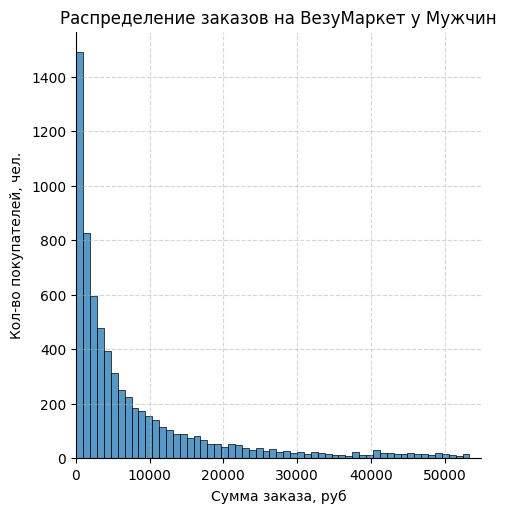

In [144]:
# визуализация
sns.displot(df_men["basket_amount"])
plt.xlabel('Сумма заказа, руб',labelpad=5)
plt.ylabel('Кол-во покупателей, чел.',labelpad=5)
plt.xlim(0, 55000)
plt.title('Распределение заказов на ВезуМаркет у Мужчин')
plt.grid(linestyle='--', alpha=0.5)
plt.show()

In [145]:
# основные показатели у мужчин
print(f'Средний чек заказа на ВезуМаркет у мужчин: {df_men["basket_amount"].mean():.0f} руб.')
print(f'Дисперсия суммы заказов на ВезуМаркет у мужчин: {df_men["basket_amount"].var():.0f} руб.')
print(f'СКО суммы заказов на ВезуМаркет у мужчин: {np.std(df_men["basket_amount"]):.0f} руб.')

Средний чек заказа на ВезуМаркет у мужчин: 8041 руб.
Дисперсия суммы заказов на ВезуМаркет у мужчин: 114344809 руб.
СКО суммы заказов на ВезуМаркет у мужчин: 10692 руб.


In [146]:
# проверка на нормальность распредления
warnings.filterwarnings('ignore')

stat1, p1 = st.shapiro(df_women["basket_amount"])
stat2, p2 = st.shapiro(df_men["basket_amount"])
if p1 > 0.05 and p2 > 0.05:
    print('Данные распределены нормально')
else:
    print('Данные распределены не нормально')

warnings.filterwarnings('default')


Данные распределены не нормально


In [147]:
# Тест Андерсона-Дарлинга
result_w = st.anderson(df_women["basket_amount"])
result_m = st.anderson(df_men["basket_amount"])

if result_w.statistic < result_w.critical_values[2] and result_m.statistic < result_m.critical_values[2]:
    print('Данные распределены нормально')
else:
    print('Данные распределены не нормально')

Данные распределены не нормально


In [148]:
# U-тест Манна-Уитни
stat, p_value = st.mannwhitneyu(df_women["basket_amount"], df_men["basket_amount"])

if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

Нет оснований отвергнуть нулевую гипотезу


#### Вывод - за исследумые период женщины потратили больше на ВезуМаркет, но при этом нет оснований отвергать, что средний чек у обоих групп различаются

## Верно ли, что женщины совершают больше покупок на ВезуМаркет?

In [149]:
freq_df = marketplace_df.groupby('sex',as_index=False) \
    .agg({'user_id':'count'}).rename(columns={'user_id':'number_of_clients'})
freq_df

,sex,number_of_clients
0,Ж,6887
1,М,6733


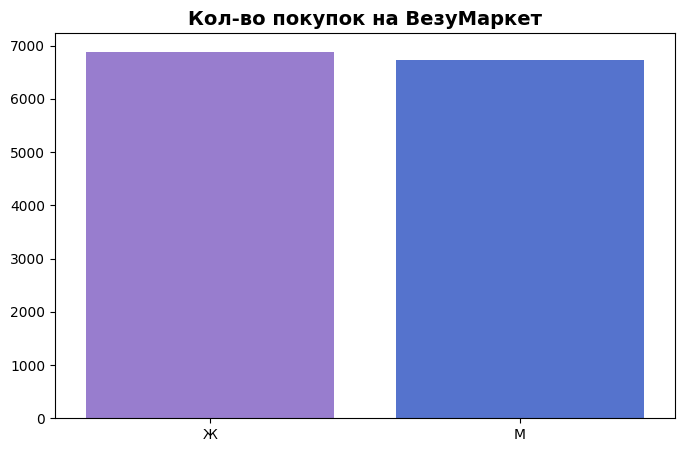

In [150]:
# визуализация
warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='sex', y='number_of_clients',data=freq_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во покупок на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

#### Вывод - за исследуемый период женщины совершали чаще покупки на ВезуМаркет

## Верно ли, что объем продаж через веб-сайт и мобильное приложение не различается?

In [151]:
marketplace_df.head()

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10


In [152]:
# кол-во уникальных записей в разрезе платформ
marketplace_df.platform.value_counts()

platform
mobile     7991
desktop    5629
Name: count, dtype: int64

In [153]:
# фильтруем датафрей по платформам
mobile_df = marketplace_df.query('platform == "mobile"')
dekstop_df = marketplace_df.query('platform == "desktop"')

In [154]:
# объемы продаж
mobile_volume = np.sum(mobile_df.number_of_products)
dekstop_volume = np.sum(dekstop_df.number_of_products)
print(f'Объем продаж через мобильное приложение: {mobile_volume} товаров')
print(f'Объем продаж через сайт: {dekstop_volume} товаров')

Объем продаж через мобильное приложение: 27799 товаров
Объем продаж через сайт: 19607 товаров


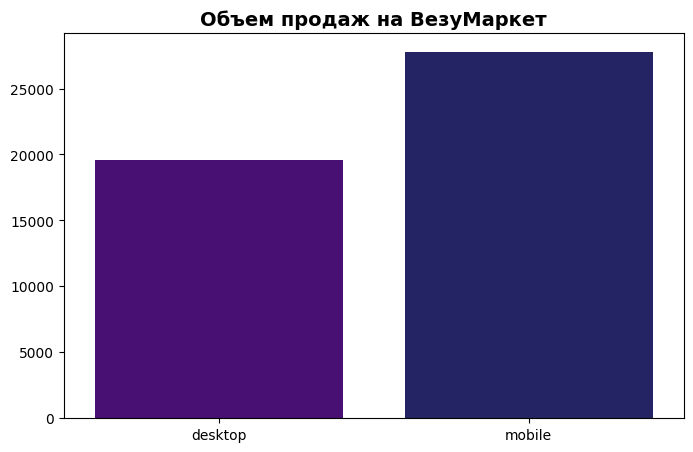

In [155]:
# визуализация
df_volume = marketplace_df.groupby('platform',as_index=False).agg({'number_of_products':'sum'})

warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='number_of_products',data=df_volume, palette=['indigo','midnightblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Объем продаж на ВезуМаркет',fontdict={'fontsize':14,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

### H0: объем продаж через веб-сайт и мобильное приложение не различается
### H1: объем продаж через веб-сайт и мобильное приложение различается

In [156]:
dekstop_df

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
1,2024-10-01 00:27:06,2024-10-01 00:38:29,2540815,М,desktop,электроника,False,0,1,162,2024-10
2,2024-10-01 00:52:36,2024-10-01 01:03:10,5305770,М,desktop,одежда и обувь,False,0,3,8188,2024-10
6,2024-10-01 01:26:42,2024-10-01 01:56:58,3365488,М,desktop,все для дома,False,0,4,23301,2024-10
7,2024-10-01 01:37:37,2024-10-01 02:11:07,6286723,Ж,desktop,красота и здоровье,False,0,6,2575,2024-10
9,2024-10-01 01:39:36,2024-10-01 02:14:10,8280464,Ж,desktop,одежда и обувь,True,13,4,26667,2024-10
...,...,...,...,...,...,...,...,...,...,...,...
13606,2024-12-31 21:49:44,2024-12-31 22:26:16,7147054,Ж,desktop,красота и здоровье,False,0,1,4347,2024-12
13613,2024-12-31 22:37:45,2024-12-31 22:55:59,4221401,М,desktop,электроника,True,7,4,167,2024-12
13617,2024-12-31 23:17:55,2024-12-31 23:28:25,3864302,Ж,desktop,красота и здоровье,False,0,3,4760,2024-12
13618,2024-12-31 23:23:46,2024-12-31 23:53:51,2361461,М,desktop,одежда и обувь,True,9,2,324,2024-12


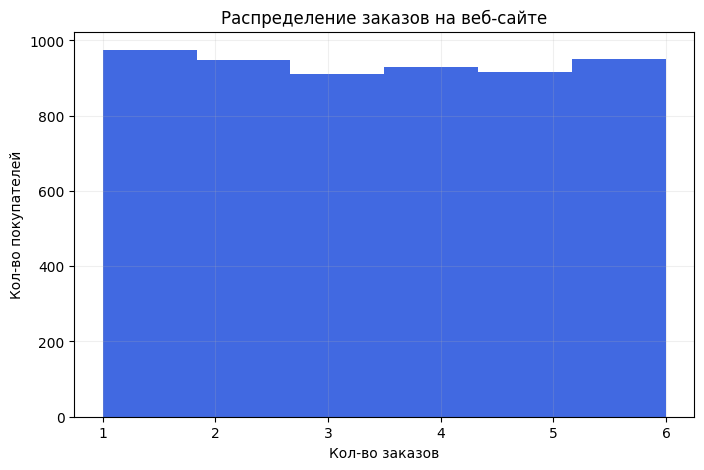

In [157]:
# визуализация
plt.figure(figsize=(8,5))
plt.hist(dekstop_df["number_of_products"], color = 'royalblue',bins=6)
plt.xlabel('Кол-во заказов')
plt.ylabel('Кол-во покупателей')
plt.title('Распределение заказов на веб-сайте')
plt.grid(True, alpha=0.2)
plt.show()

In [158]:
# основные показатели
print(f"Среднее количество товаров: {dekstop_df['number_of_products'].mean():.2f}")
print(f"Медиана: {dekstop_df['number_of_products'].median():.2f}")
print(f"Мода: {dekstop_df['number_of_products'].mode()[0]}")
print(f"Std: {dekstop_df['number_of_products'].std():.2f}")
print(f"Минимум: {dekstop_df['number_of_products'].min()}")
print(f"Максимум: {dekstop_df['number_of_products'].max()}")

Среднее количество товаров: 3.48
Медиана: 3.00
Мода: 1
Std: 1.72
Минимум: 1
Максимум: 6


In [159]:
mobile_df

,start_session,end_session,user_id,sex,platform,category,consultation,cons_duration,number_of_products,basket_amount,month
0,2024-10-01 00:15:51,2024-10-01 00:55:17,5209870,М,mobile,товары для животных,True,13,1,348,2024-10
3,2024-10-01 01:04:17,2024-10-01 01:39:10,5858087,М,mobile,одежда и обувь,False,0,5,11640,2024-10
4,2024-10-01 01:08:44,2024-10-01 01:21:21,5711053,Ж,mobile,одежда и обувь,False,0,1,2438,2024-10
5,2024-10-01 01:23:00,2024-10-01 01:52:18,3046228,М,mobile,одежда и обувь,True,10,5,11364,2024-10
8,2024-10-01 01:38:22,2024-10-01 01:56:48,8145525,Ж,mobile,одежда и обувь,True,8,2,10430,2024-10
...,...,...,...,...,...,...,...,...,...,...,...
13611,2024-12-31 22:19:13,2024-12-31 22:41:45,7046417,Ж,mobile,одежда и обувь,True,11,3,1939,2024-12
13612,2024-12-31 22:24:40,2024-12-31 22:34:54,6543447,М,mobile,товары для животных,False,0,4,904,2024-12
13614,2024-12-31 22:45:30,2024-12-31 23:06:44,4283046,Ж,mobile,детские товары,False,0,3,6299,2024-12
13615,2024-12-31 22:58:24,2024-12-31 23:11:40,7766167,М,mobile,одежда и обувь,False,0,3,1632,2024-12


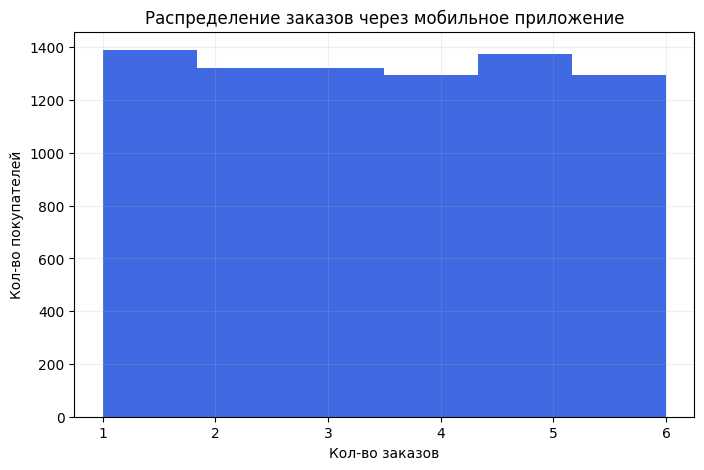

In [160]:
# визуализация
plt.figure(figsize=(8,5))
plt.hist(mobile_df["number_of_products"], color = 'royalblue',bins=6)
plt.xlabel('Кол-во заказов')
plt.ylabel('Кол-во покупателей')
plt.title('Распределение заказов через мобильное приложение')
plt.grid(True, alpha=0.2)
plt.show()

In [161]:
# основные показатели
print(f"Среднее количество товаров: {mobile_df['number_of_products'].mean():.2f}")
print(f"Медиана: {mobile_df['number_of_products'].median():.2f}")
print(f"Мода: {mobile_df['number_of_products'].mode()[0]}")
print(f"Std: {mobile_df['number_of_products'].std():.2f}")
print(f"Минимум: {mobile_df['number_of_products'].min()}")
print(f"Максимум: {mobile_df['number_of_products'].max()}")

Среднее количество товаров: 3.48
Медиана: 3.00
Мода: 1
Std: 1.71
Минимум: 1
Максимум: 6


#### Основываясь на статистических показателях, мы не стали проверять гипотезы, так как объем продаж через мобильное приложение выше только лишь за счет количества заказов, но само распределение одинаковое.

## Верно ли, что через мобильное приложение и веб-сайт покупки совершает одинаковое количество покупателей?

In [162]:
# кол-во уникальных пользователей на кажой платформе
users_df = marketplace_df.groupby('platform', as_index=False) \
    .agg({'user_id':'nunique'}).rename(columns={'user_id':'users'})
users_df

,platform,users
0,desktop,4580
1,mobile,5992


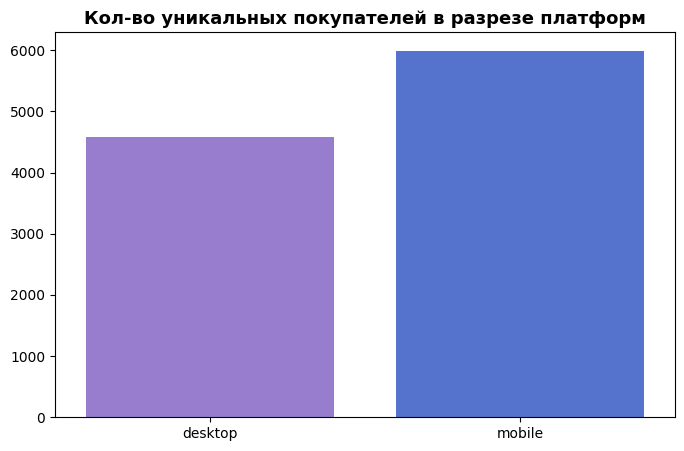

In [163]:
# визуализация
warnings.filterwarnings('ignore')

plt.figure(figsize=(8,5))
sns.barplot(x='platform', y='users',data=users_df, palette=['mediumpurple','royalblue'])
plt.ylabel('')
plt.xlabel('')
plt.title('Кол-во уникальных покупателей в разрезе платформ',fontdict={'fontsize':13,'fontweight':'bold'})
plt.show()

warnings.filterwarnings('default')

### H0: через мобильное приложение и веб-сайт покупки совершает одинаковое кол-во покупателей
### H1: через мобильное приложение и веб-сайт покупки совершает разное кол-во покупателей

In [164]:
# общее и уникальное кол-во пользователей
dekstop_users = dekstop_df.shape[0]
mobile_users = mobile_df.shape[0]
dekstop_uniq = users_df.users[0]
monile_uniq = users_df.users[1]

In [165]:
# Z-тест для пропорций 
count=[dekstop_uniq,monile_uniq]
nobs = [dekstop_users,mobile_users]

z_stat, p_value = proportions_ztest(count, nobs, alternative='two-sided')
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value}")

if p_value < 0.05:
    print('Количество покупателей различается, есть статистически значимые различия')
else:
    print('Количество покупателей одинаково, нет статистически значимых различий')

Z-статистика: 8.7971
p-value: 1.4039151313786243e-18
Количество покупателей различается, есть статистически значимые различия


#### Вывод - через мобильное приложение и веб-сайт покупки совершает разное кол-во покупателей 

## Верно ли, что через мобильное приложение покупатели чаще обращаются за консультацией?

# Аналитика по чат-боту

## Расчет интенсивности и среднего времени обслуживания на основе данных из датасета

In [166]:
# Считаем mu (Среднее время обслуживания). Берем только те строки, где была консультация
cons_df = marketplace_df[marketplace_df['consultation'] == True]
mu = cons_df['cons_duration'].mean()

# Количество консультаций
total_consultations = len(cons_df)

# Общее время работы магазина в минутах (от первого до последнего заказа)
total_time_minutes = (marketplace_df['end_session'].max() - marketplace_df['start_session'].min()).total_seconds() / 60

# Считаем lmbd (Интенсивность)
lmbd = total_consultations / total_time_minutes

print(f"Среднее время (mu): {mu:.2f} мин")
print(f"Интенсивность (lmbd): {lmbd:.4f} заявок/мин")

Среднее время (mu): 9.51 мин
Интенсивность (lmbd): 0.0408 заявок/мин


## Симуляция обработки звонков с фиксированным кол-вом операторов

Лимит 1: обработано 6120, сброшено 1761 (28.8%)
Лимит 2: обработано 6164, сброшено 311 (5.0%)
Лимит 3: обработано 6047, сброшено 39 (0.6%)
Лимит 4: обработано 5931, сброшено 9 (0.2%)
Лимит 5: обработано 6117, сброшено 0 (0.0%)

Анализ оптимального лимита
Целевая вероятность сброса P <= 10.0%
Лимит N=1: P = 28.8% - НЕдостаточен
Лимит N=2: P = 5.0% - достаточен
Лимит N=3: P = 0.6% - достаточен
Лимит N=4: P = 0.2% - достаточен
Лимит N=5: P = 0.0% - достаточен

Рекомендуемый лимит чат-бота: 2


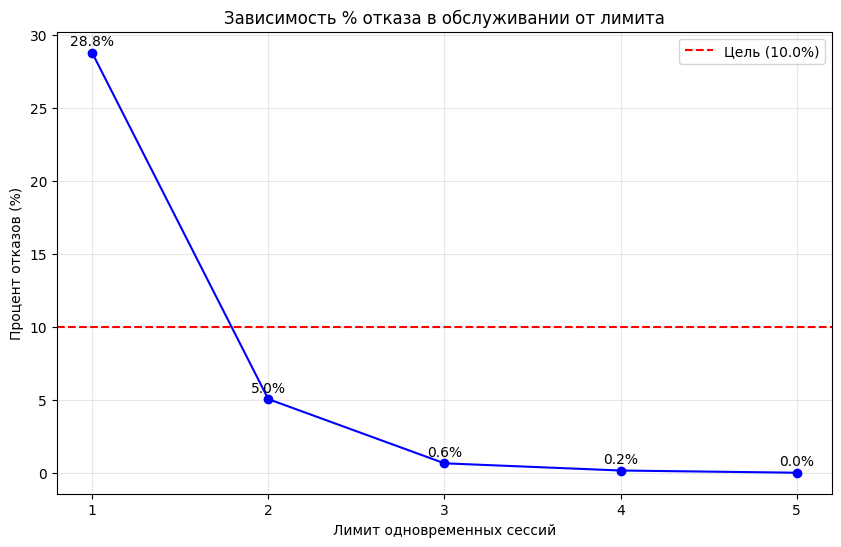

In [169]:
import simpy
import random
import statistics

# Параметры Моделирования
lmbd = 0.0408 # Интенсивность (запросов/мин)
mu = 9.51 # Среднее время обслуживания (мин/запрос)
SIM_TIME = 150000 # Время моделирования (мин)

# Глобальные счетчики
abandoned_requests = 0
total_arrivals = 0

def request_generator(env, bot, limit): # Генерируем приход запросов (покупателей, нуждающихся в консультации)
    global total_arrivals
    while True:
        yield env.timeout(random.expovariate(lmbd))
        total_arrivals += 1
        env.process(consultation_process(env, bot))

def consultation_process(env, bot): #Процесс обслуживания
    global abandoned_requests

    # проверка лимита:
    # Если занятых слотов >= вместимости, уходим
    if bot.count >= bot.capacity:
        abandoned_requests += 1
        return

    # Если место есть, занимаем его
    with bot.request() as req:
        yield req

        # Обслуживание
        service_duration = random.expovariate(1.0 / mu)
        yield env.timeout(service_duration)

def run_simulation(limit): #Запуск симуляции с заданным лимитом
    global abandoned_requests, total_arrivals

    # Сброс статистики
    abandoned_requests = 0
    total_arrivals = 0

    env = simpy.Environment()

    bot = simpy.Resource(env, capacity=limit)

    env.process(request_generator(env, bot, limit))
    env.run(until=SIM_TIME)

    # Расчет метрик
    prob_drop = abandoned_requests / total_arrivals if total_arrivals > 0 else 0
    return prob_drop, total_arrivals, abandoned_requests

if __name__ == "__main__":
    limits = range(1, 6)
    results = [] # Список для хранения результатов

    target_prob = 0.1 # Цель не более 10% сбросов

    for limit in limits:
        prob, total, abandoned = run_simulation(limit)
        results.append((limit, prob * 100))
        print(f"Лимит {limit}: обработано {total}, сброшено {abandoned} ({prob:.1%})")

    print("\nАнализ оптимального лимита")
    print(f"Целевая вероятность сброса P <= {target_prob*100}%")

    optimal_limit = None

    probabilities = []

    for limit, p_percent in results:
        probabilities.append(p_percent)

        status = "достаточен" if p_percent/100 <= target_prob else "НЕдостаточен"
        print(f"Лимит N={limit}: P = {p_percent:.1f}% - {status}")

        if optimal_limit is None and p_percent/100 <= target_prob:
            optimal_limit = limit

    if optimal_limit:
        print(f"\nРекомендуемый лимит чат-бота: {optimal_limit}")
    else:
        print("\nНужно протестировать большие лимиты")

    # построение графика
    plt.figure(figsize=(10, 6))
    plt.plot(limits, probabilities, marker='o', linestyle='-', color='b')
    plt.axhline(y=target_prob*100, color='r', linestyle='--', label=f'Цель ({target_prob*100}%)')

    plt.title('Зависимость % отказа в обслуживании от лимита')
    plt.xlabel('Лимит одновременных сессий')
    plt.ylabel('Процент отказов (%)')
    plt.grid(True, alpha=0.3)
    plt.xticks(limits)
    plt.legend()

    for x, y in zip(limits, probabilities):
        plt.text(x, y + 0.5, f"{y:.1f}%", ha='center')

    plt.show()

## Математическая проверка по формуле Эрланга-B

In [170]:
def erlang_b(traffic, lines):
    inv_b = 1.0
    for n in range(1, lines + 1):
        inv_b = 1.0 + (inv_b * n / traffic)
    return 1.0 / inv_b

lmbd = 0.0408  # запросов в минуту
mu = 9.51        # минут на запрос
traffic_load = lmbd * mu # нагрузка в Эрлангах

print(f"Нагрузка: {traffic_load:.2f} Erlang")
print("-" * 30)

# Считаем вероятность вызова оператора для разных лимитов
for limit in range(1, 6):
    prob_blocking = erlang_b(traffic_load, limit)
    print(f"Лимит {limit}: Вероятность вызова оператора = {(prob_blocking*100):.1f}%")

    if prob_blocking <= 0.1:
         print(f"   >>> Лимит {limit} подходит (<= 10%)")

Нагрузка: 0.39 Erlang
------------------------------
Лимит 1: Вероятность вызова оператора = 28.0%
Лимит 2: Вероятность вызова оператора = 5.1%
   >>> Лимит 2 подходит (<= 10%)
Лимит 3: Вероятность вызова оператора = 0.7%
   >>> Лимит 3 подходит (<= 10%)
Лимит 4: Вероятность вызова оператора = 0.1%
   >>> Лимит 4 подходит (<= 10%)
Лимит 5: Вероятность вызова оператора = 0.0%
   >>> Лимит 5 подходит (<= 10%)


#### Математический расчет подтверждает результаты, полученные в симуляции

## Эффективность минуты

In [171]:
marketplace_df['cons_duration'] = pd.to_numeric(marketplace_df['cons_duration'])

cons_df = marketplace_df[marketplace_df['consultation'] == True].copy()
cons_df['rpm'] = cons_df['basket_amount'] / cons_df['cons_duration']

efficiency = cons_df.groupby('category')['rpm'].median().sort_values(ascending=False)

print("Медианная выручка за минуту консультации, руб/мин:")
print(efficiency)

Медианная выручка за минуту консультации, руб/мин:
category
электроника            2147.166667
одежда и обувь          680.035714
детские товары          546.000000
все для дома            415.642857
красота и здоровье      223.135714
канцелярия               93.800000
товары для животных      68.083333
Name: rpm, dtype: float64


На какую категорию выгоднее тратить время оператора/бота?
Посчитали выручку за минуту консультации.

Результаты:

Электроника: ~3000 руб./мин. Самая выгодная категория. Одна минута разговора здесь приносит в 10 раз больше выручки, чем в Канцелярии.

Канцелярия и Животные: ~140-200 руб./мин. Здесь консультации экономически неэффективны для живого человека.

Решение: Настроить бота так, чтобы в категории Электроника он быстрее переключал на живого оператора, а в Канцелярии старался решить все сам до последнего.

## Сегментация пользователей

In [173]:
# Считаем для каждого пользователя, сколько заказов всего и сколько с консультацией
user_stats = marketplace_df.groupby('user_id').agg({'consultation': ['count', 'sum']})
user_stats.columns = ['total_orders', 'consulted_orders']
# Берем только тех, кто покупал больше 1 раза
loyal_users = user_stats[user_stats['total_orders'] > 1].copy()
loyal_users['cons_ratio'] = loyal_users['consulted_orders'] / loyal_users['total_orders']

# Категоризация
conditions = [(loyal_users['cons_ratio'] == 0), (loyal_users['cons_ratio'] == 1)]
choices = ['Self-sufficient', 'Needs Support']
loyal_users['type'] = np.select(conditions, choices, default='Mixed')

print("Типы лояльных клиентов:")
print(loyal_users['type'].value_counts(normalize=True))

Типы лояльных клиентов:
type
Mixed              0.546567
Self-sufficient    0.320823
Needs Support      0.132611
Name: proportion, dtype: float64


Есть ли люди, которые всегда пишут в чат? Мы проанализировали постоянных клиентов (>1 заказа):

13% клиентов - Абсолютно зависимые. Они пишут в чат при каждом заказе.

32% - Самостоятельные. Никогда не пишут.

55% - Смешанные.

Решение: Для тех 13% можно сразу открывать окно чата при входе в приложение, так как мы знаем, что они все равно туда напишут.

## Зависимость от размера чека и корзины

In [174]:
# Считаем общее число сессий
total_sessions = len(marketplace_df)

# Считаем число консультаций
total_consultations = marketplace_df['consultation'].sum()

# Вычисляем долю
probability = total_consultations / total_sessions


print(f"Всего заказов: {total_sessions}")
print(f"Заказов с консультацией: {total_consultations}")
print(f"Доля консультаций: {probability*100:.1f}%")

Всего заказов: 13620
Заказов с консультацией: 5399
Доля консультаций: 39.6%


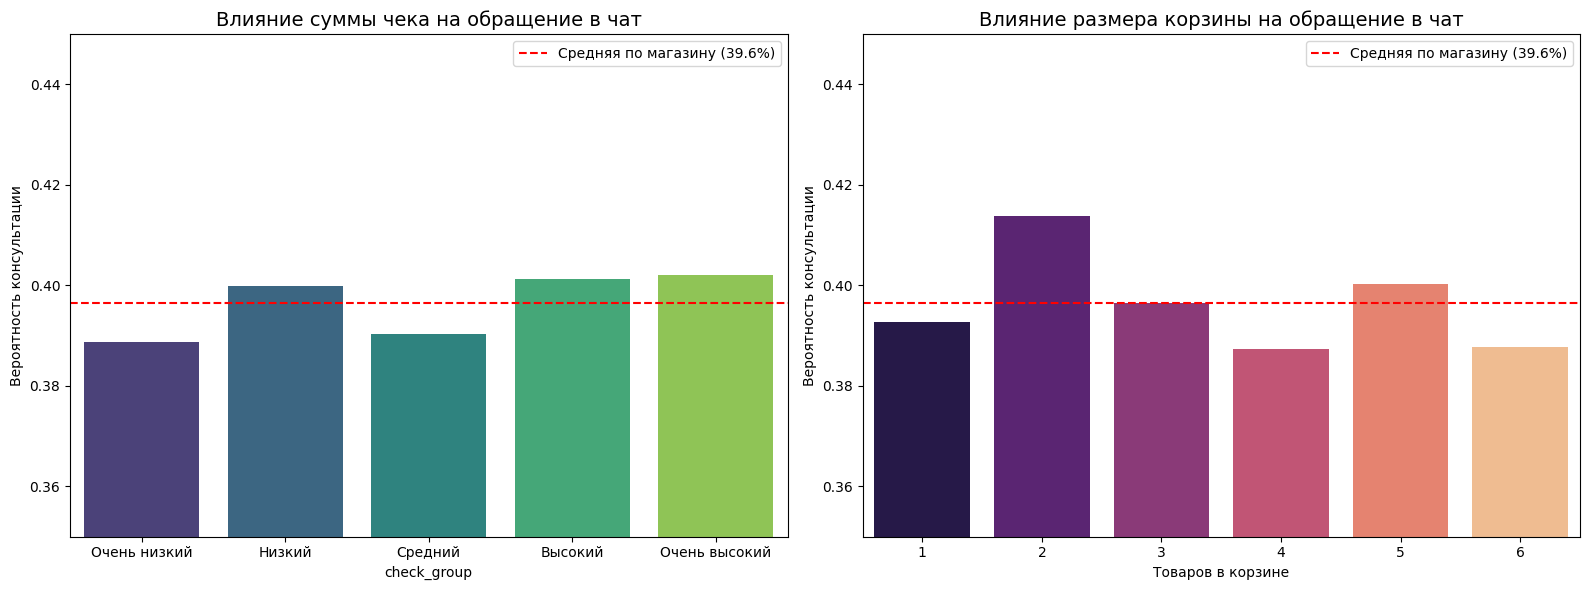

In [178]:
warnings.filterwarnings('ignore')

# Разбиваем чеки на 5 равных групп от самых экономных до транжир
marketplace_df['check_group'] = pd.qcut(marketplace_df['basket_amount'], q=5, labels=['Очень низкий', 'Низкий', 'Средний', 'Высокий', 'Очень высокий'])

# Считаем вероятность консультации для каждой группы
check_stats = marketplace_df.groupby('check_group')['consultation'].mean().reset_index()

# Считаем вероятность для каждого кол-ва товаров
prod_stats = marketplace_df.groupby('number_of_products')['consultation'].mean().reset_index()

# Ограничим график до 6 товаров (так как корзин с 7+ товарами очень мало)
prod_stats_filtered = prod_stats[prod_stats['number_of_products'] <= 6]


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1 Влияние суммы чека
sns.barplot(data=check_stats, x='check_group', y='consultation', ax=axes[0], palette='viridis')
axes[0].set_title('Влияние суммы чека на обращение в чат', fontsize=14)
axes[0].set_ylabel('Вероятность консультации')
axes[0].set_ylim(0.35, 0.45)
axes[0].axhline(y=marketplace_df['consultation'].mean(), color='red', linestyle='--', label='Средняя по магазину (39.6%)')
axes[0].legend()

# График 2 Влияние размера корзины
sns.barplot(data=prod_stats_filtered, x='number_of_products', y='consultation', ax=axes[1], palette='magma')
axes[1].set_title('Влияние размера корзины на обращение в чат', fontsize=14)
axes[1].set_ylabel('Вероятность консультации')
axes[1].set_xlabel('Товаров в корзине')
axes[1].set_ylim(0.35, 0.45)
axes[1].axhline(y=marketplace_df['consultation'].mean(), color='red', linestyle='--', label='Средняя по магазину (39.6%)')
axes[1].legend()

plt.tight_layout()
plt.show()

warnings.filterwarnings('default')

Нужна ли консультация чаще, если чек большой?

Результат:

Удивительно, но нет. Вероятность консультации стабильна (~39-40%) и для чеков Эконом, и для Премиум. То же самое с количеством товаров (от 1 до 6 товаров вероятность одинаковая).

Вывод: Люди обращаются в поддержку не из-за сложности заказа, а скорее всего из-за стандартных сервисных вопросов (доставка, оплата), которые возникают при любой покупке. Это идеальный кейс для полной автоматизации.

## Матрица спроса

Text(0.5, 1.0, 'Вероятность консультации')

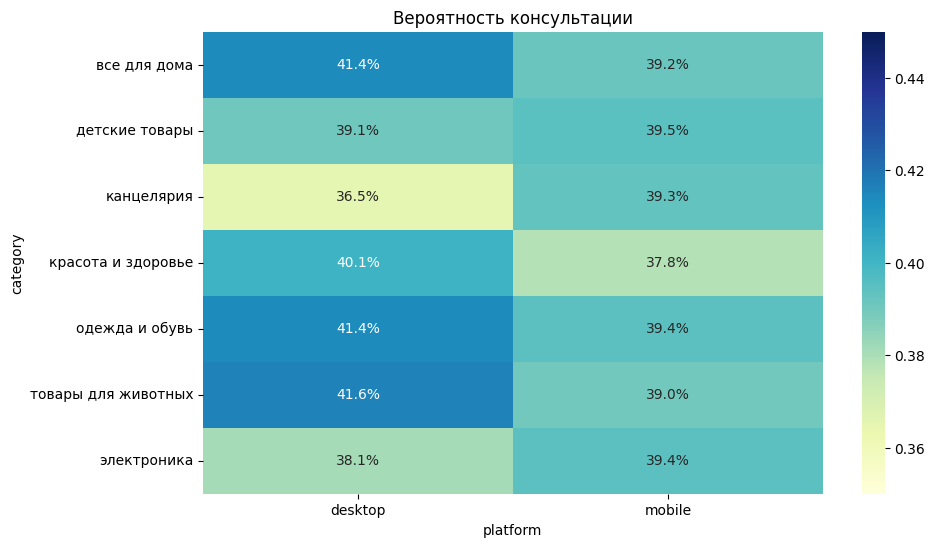

In [176]:
plt.figure(figsize=(10, 6))
pivot = marketplace_df.pivot_table(index='category', columns='platform', values='consultation', aggfunc='mean')
sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt='.1%', vmin=0.35, vmax=0.45)
plt.title('Вероятность консультации')

Где пользователи чаще всего просят помощи?

Результат:

В целом, поведение пользователей на сайте и в приложении очень похоже. Это значит, что можно использовать единый сценарий для бота на обеих платформах.